In [1]:
import harvest_arxiv
import pandas as pd
import numpy as np
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import movie_reviews
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.probability import FreqDist
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer
from matplotlib.ticker import FuncFormatter
import numpy as np
import sklearn
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import PredefinedSplit
from sklearn.pipeline import FeatureUnion
import keras
import time
import urllib
import datetime
from collections import Counter, defaultdict
import xml.etree.ElementTree as ET
from bs4 import BeautifulSoup
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import bibtexparser

Using TensorFlow backend.


In [2]:
print("sklearn version:",sklearn.__version__)
print("nltk version:", nltk.__version__)
print("tensorflow version:", tf.__version__)
print("keras version:", keras.__version__)

sklearn version: 0.20.2
nltk version: 3.2.4
tensorflow version: 1.12.0
keras version: 2.2.4


In [3]:
##to harvest math arxiv data and save the file as a csv file
if "complete_math_arxiv.csv" not in os.listdir():
    df = harvest_arxiv.harvest(arxiv="math", start="1989-01-01", end="2018-12-31")
    df.to_csv("complete_math_arxiv.csv",index=False,encoding="utf-8")
    del df

In [4]:
##assume we have it 
df = pd.read_csv("complete_math_arxiv.csv")

/Users/ben/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## let's take a look of the dataframe

In [5]:
df.head()

,abstract,authors,categories,created,id,title,updated
0,We construct a generic extension in which the ...,"['Thomas Jech', 'Saharon Shelah']",['math.LO'],1989-04-14,math/9201239,A note on canonical functions,1989-04-14
1,It is shown that if $C$ is an $n$-dimensional ...,['Keith Ball'],"['math.MG', 'math.FA']",1989-10-26,math/9201205,Volume ratios and a reverse isoperimetric ineq...,1989-10-26
2,It is proved that if $C$ is a convex body in $...,['Keith Ball'],"['math.MG', 'math.FA']",1989-10-26,math/9201204,Shadows of convex bodies,1989-10-26
3,"It is proved that if $u_1,\ldots, u_n$ are vec...","['Keith Ball', 'Alain Pajor']","['math.MG', 'math.FA']",1989-10-26,math/9201203,Convex bodies with few faces,1989-10-26
4,"This note deals with the following problem, th...","['Gideon Schechtman', 'Joel Zinn']","['math.FA', 'math.MG']",1989-11-09,math/9201206,On the volume of the intersection of two $L_p^...,1989-11-09


####  the authors and categories are string, we need to reformat them

In [6]:
def list_of_authors(text):
    names=[]
    name_list=text.split(',')
    for name in name_list:
        name=name.strip()
        if name[0]=='[':
            name=name[1:]
        if name[-1]==']':
            name=name[:-1]
        name=name[1:-1]
        names+=[name]
    return names    


def list_of_categories(text):
    pat=re.compile(r'math.[A-Z][A-Z]')
    return pat.findall(text)

##now we can make them into a list
df['categories']=df['categories'].apply(lambda x: list_of_categories(x))
df['authors']=df['authors'].apply(lambda x: list_of_authors(x))
df['created']=df['created'].apply(lambda x:datetime.datetime.strptime(x, "%Y-%m-%d"))

## There are many different categories but what are the meaning of them?

In [7]:
###to understand the abbreviation 
url="https://arxiv.org/archive/math"
response = urllib.request.urlopen(url)
soup = BeautifulSoup(response.read(), 'html.parser')
ulTag = soup.find_all("ul")
###we only want the liTag which contains information of category description
for liTag in ulTag:
    if "math.AG" in str(liTag):
        break
need_ul=liTag
cat_long_description={}
cat_short_description={}
for liTag in need_ul.find_all("li"):
    cat,short=liTag.b.string.split(" - ")
    cat_short_description[cat]=short
    cat_long_description[cat]=list(liTag.div.stripped_strings)[0]

### It will generate description of a category . For example, let consider math.RT

In [8]:
def show_description(cat):

    print("Category:",cat)
    print()
    print("Name:",cat_short_description[cat])
    print()
    print("description:",cat_long_description[cat])
    
show_description("math.AG")    

Category: math.AG

Name: Algebraic Geometry

description: Algebraic varieties, stacks, sheaves, schemes, moduli spaces, complex geometry, quantum cohomology


### In order to do NLP on the abstract of the math paper, we should also remove all math symbol (i.e. latex) and other symbols

In [9]:

def cancelmath_and_quote(test_str):
    regex = r"\n"
    
    subst = " "

    result = re.sub(regex, subst, test_str, 0, re.MULTILINE) 
    
    ##delete all latex 
    regex = r"(\$+)(?:(?!\1)[\s\S])*\1"

    subst = ""
    result = re.sub(regex, subst, result, 0, re.MULTILINE)
    ##delete all references
    regex = r"[\(\[].*?[\)\]]"
    
    subst = ""

    result = re.sub(regex, subst, result, 0, re.MULTILINE)
    
    
    ###and remove all symbols
    
    #regex = r"[\$\+\&\%\!\`\~{}\\']"

    #subst = ""

    #result = re.sub(regex, subst, result, 0, re.MULTILINE) 
    
    regex = r"\B\-"
    
    subst = ""

    result = re.sub(regex, subst, result, 0, re.MULTILINE) 
    

    
    return result

df['abstract']=df['abstract'].apply(lambda x : cancelmath_and_quote(x))
df['title']=df['title'].apply(lambda x : cancelmath_and_quote(x))

### we have deleted all symbols in title and abstract , now take look of the dataframe again

In [10]:
df.sample(10,random_state=0)

,abstract,authors,categories,created,id,title,updated
151933,The graph realization problem has received a g...,"[Mihai Cucuringu, Amit Singer, David Cowburn]",[math.CO],2011-11-09,1111.33,"Eigenvector Synchronization, Graph Rigidity an...",2012-03-01
331069,"We consider a wireless sensor network , consis...","[Zahra Hajibabaei, Jalil Modares, Azadeh Vosou...",[math.IT],2017-06-15,1706.05,On M-ary Distributed Detection for Power Const...,2017-08-21
63554,We investigate the decoding region for Algebra...,"[Andrew Duggan, Alexander Barg]",[math.IT],2007-01-03,cs/0701018,Performance Analysis of Algebraic Soft-Decisio...,2007-01-03
300987,A friend of 12 is a positive integer different...,[Doyon Kim],"[math.HO, math.NT]",2016-08-19,1608.07,Friends of 12,2016-08-19
321419,We introduce seven families of stochastic syst...,[Makoto Katori],"[math.PR, math.MP]",2017-03-11,1703.04,Elliptic Determinantal Processes and Elliptic ...,2017-10-04
292976,An oriented cycle is an orientation of a undir...,"[Nathann Cohen, Frédéric Havet, William Lochet...",[math.CO],2016-05-25,1605.08,Subdivisions of oriented cycles in digraphs wi...,2016-05-25
55714,Suppose that f is a boolean function from F_2^...,"[Ben Green, Tom Sanders]","[math.CA, math.CO]",2006-05-18,math/0605524,Boolean functions with small spectral norm,2010-04-01
161860,A transform approach to network coding was int...,"[Abhinav Ganesan, Teja Damodaram Bavirisetti, ...",[math.IT],2012-03-27,1203.59,On the Feasibility of Network Alignment for Th...,2012-03-27
37872,The paper gives a brief account of the spaces ...,[Roumen Anguelov],"[math.GM, math.AP]",2004-08-02,math/0408013,An Introduction to Some Spaces of Interval Fun...,2004-08-02
352096,Various studies have confirmed the possibility...,[Won-Kwang Park],[math.NA],2018-01-08,1801.03,Detection of small inhomogeneities via direct ...,2018-01-08


In [11]:
###Let's drop all papers without math categories
df=df[df.categories.apply(lambda x: len(x)>0)]

### how many different math categories are there?

In [12]:
all_cat={}
for i in df.index:
    paper_cats=df.loc[i,"categories"]
    for cat in paper_cats:
        if cat in all_cat:
            all_cat[cat]+=1
        else:
            all_cat[cat]=1
            
list_of_all_cat=sorted(list(all_cat.items()),key=lambda x: x[1], reverse=True)            

### Let's create a barplot and see its distribution

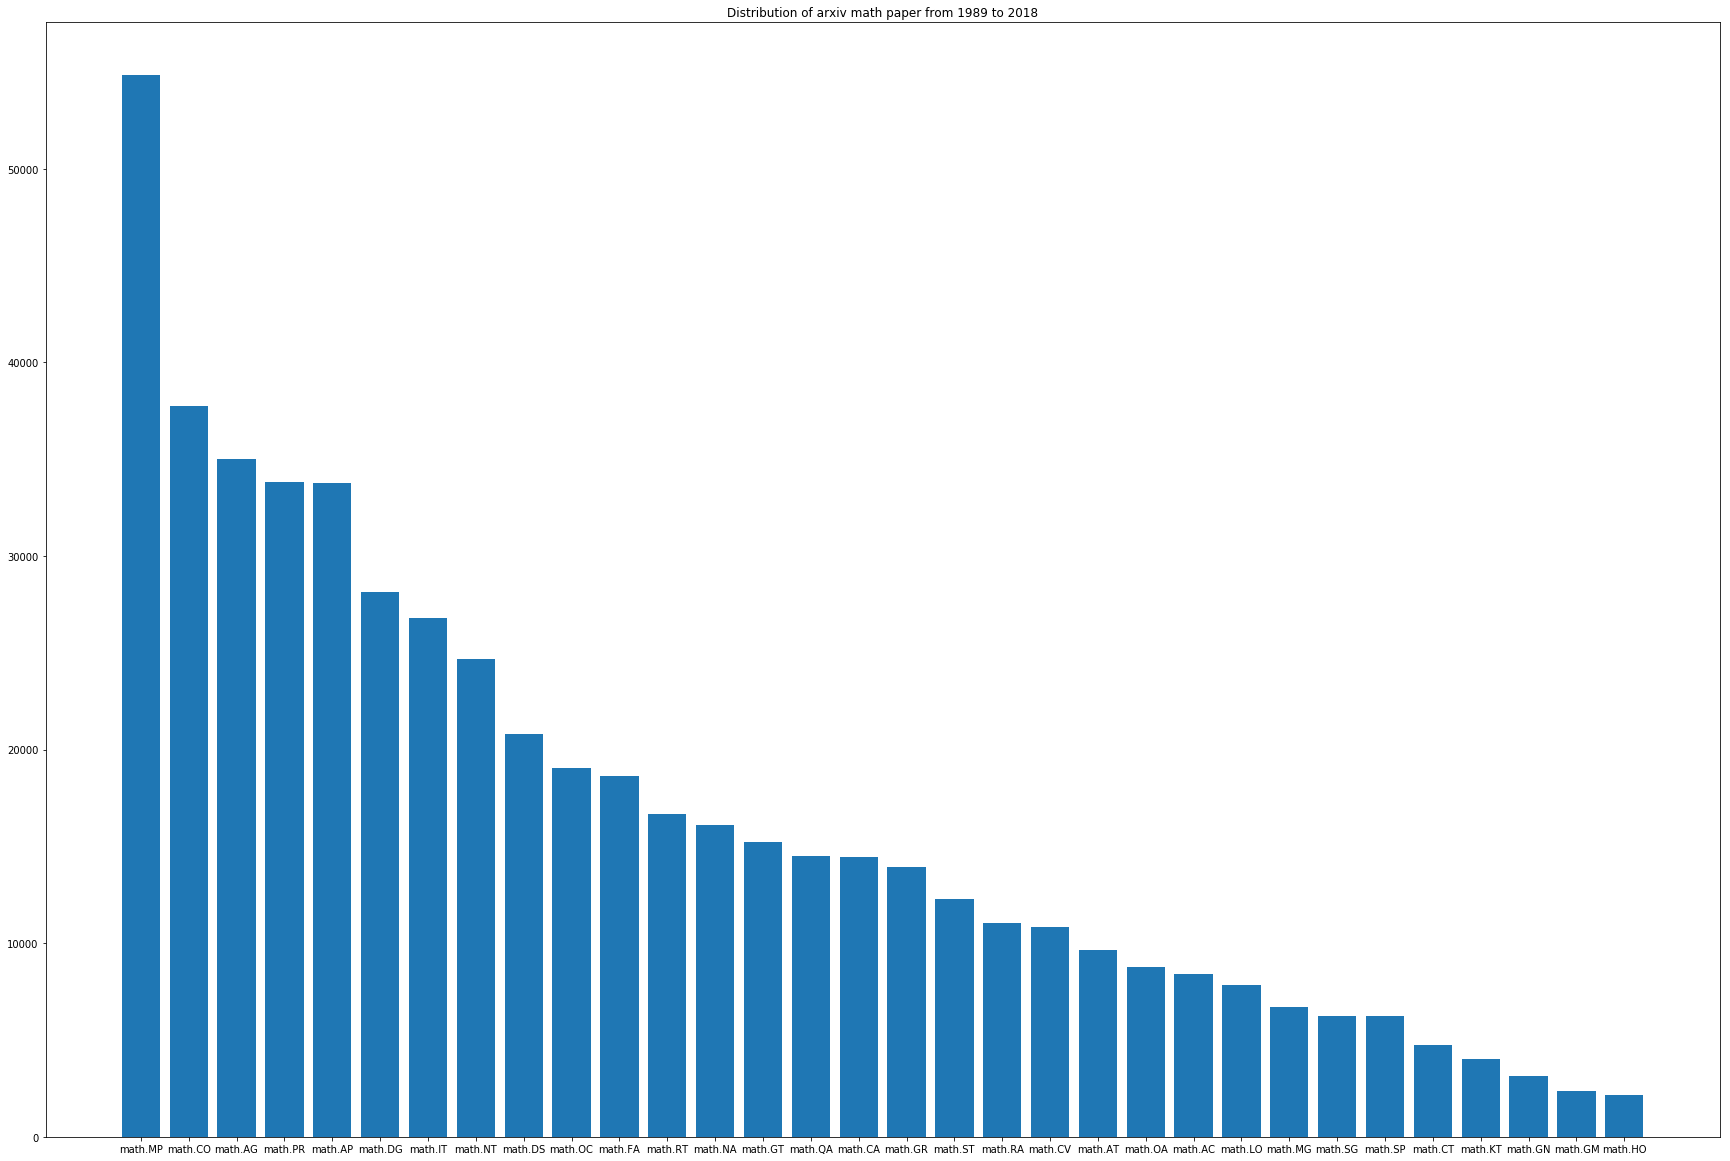

In [13]:
X_cat,Y_cat=list(zip(*list_of_all_cat))
fig, ax = plt.subplots()
fig.set_size_inches(30, 20.5)
plt.bar(X_cat, Y_cat)
# plt.figure(figsize=(200,200))
#plt.xticks(x, ('Bill', 'Fred', 'Mary', 'Sue'))
plt.title("Distribution of arxiv math paper from 1989 to 2018")
plt.show()

### So the winner is math.MP (Mathematical Physics) , runner up is Combinatorics and 2nd runner up is Algebraic geometry. 

### Let's take a look of the keywords of math papers

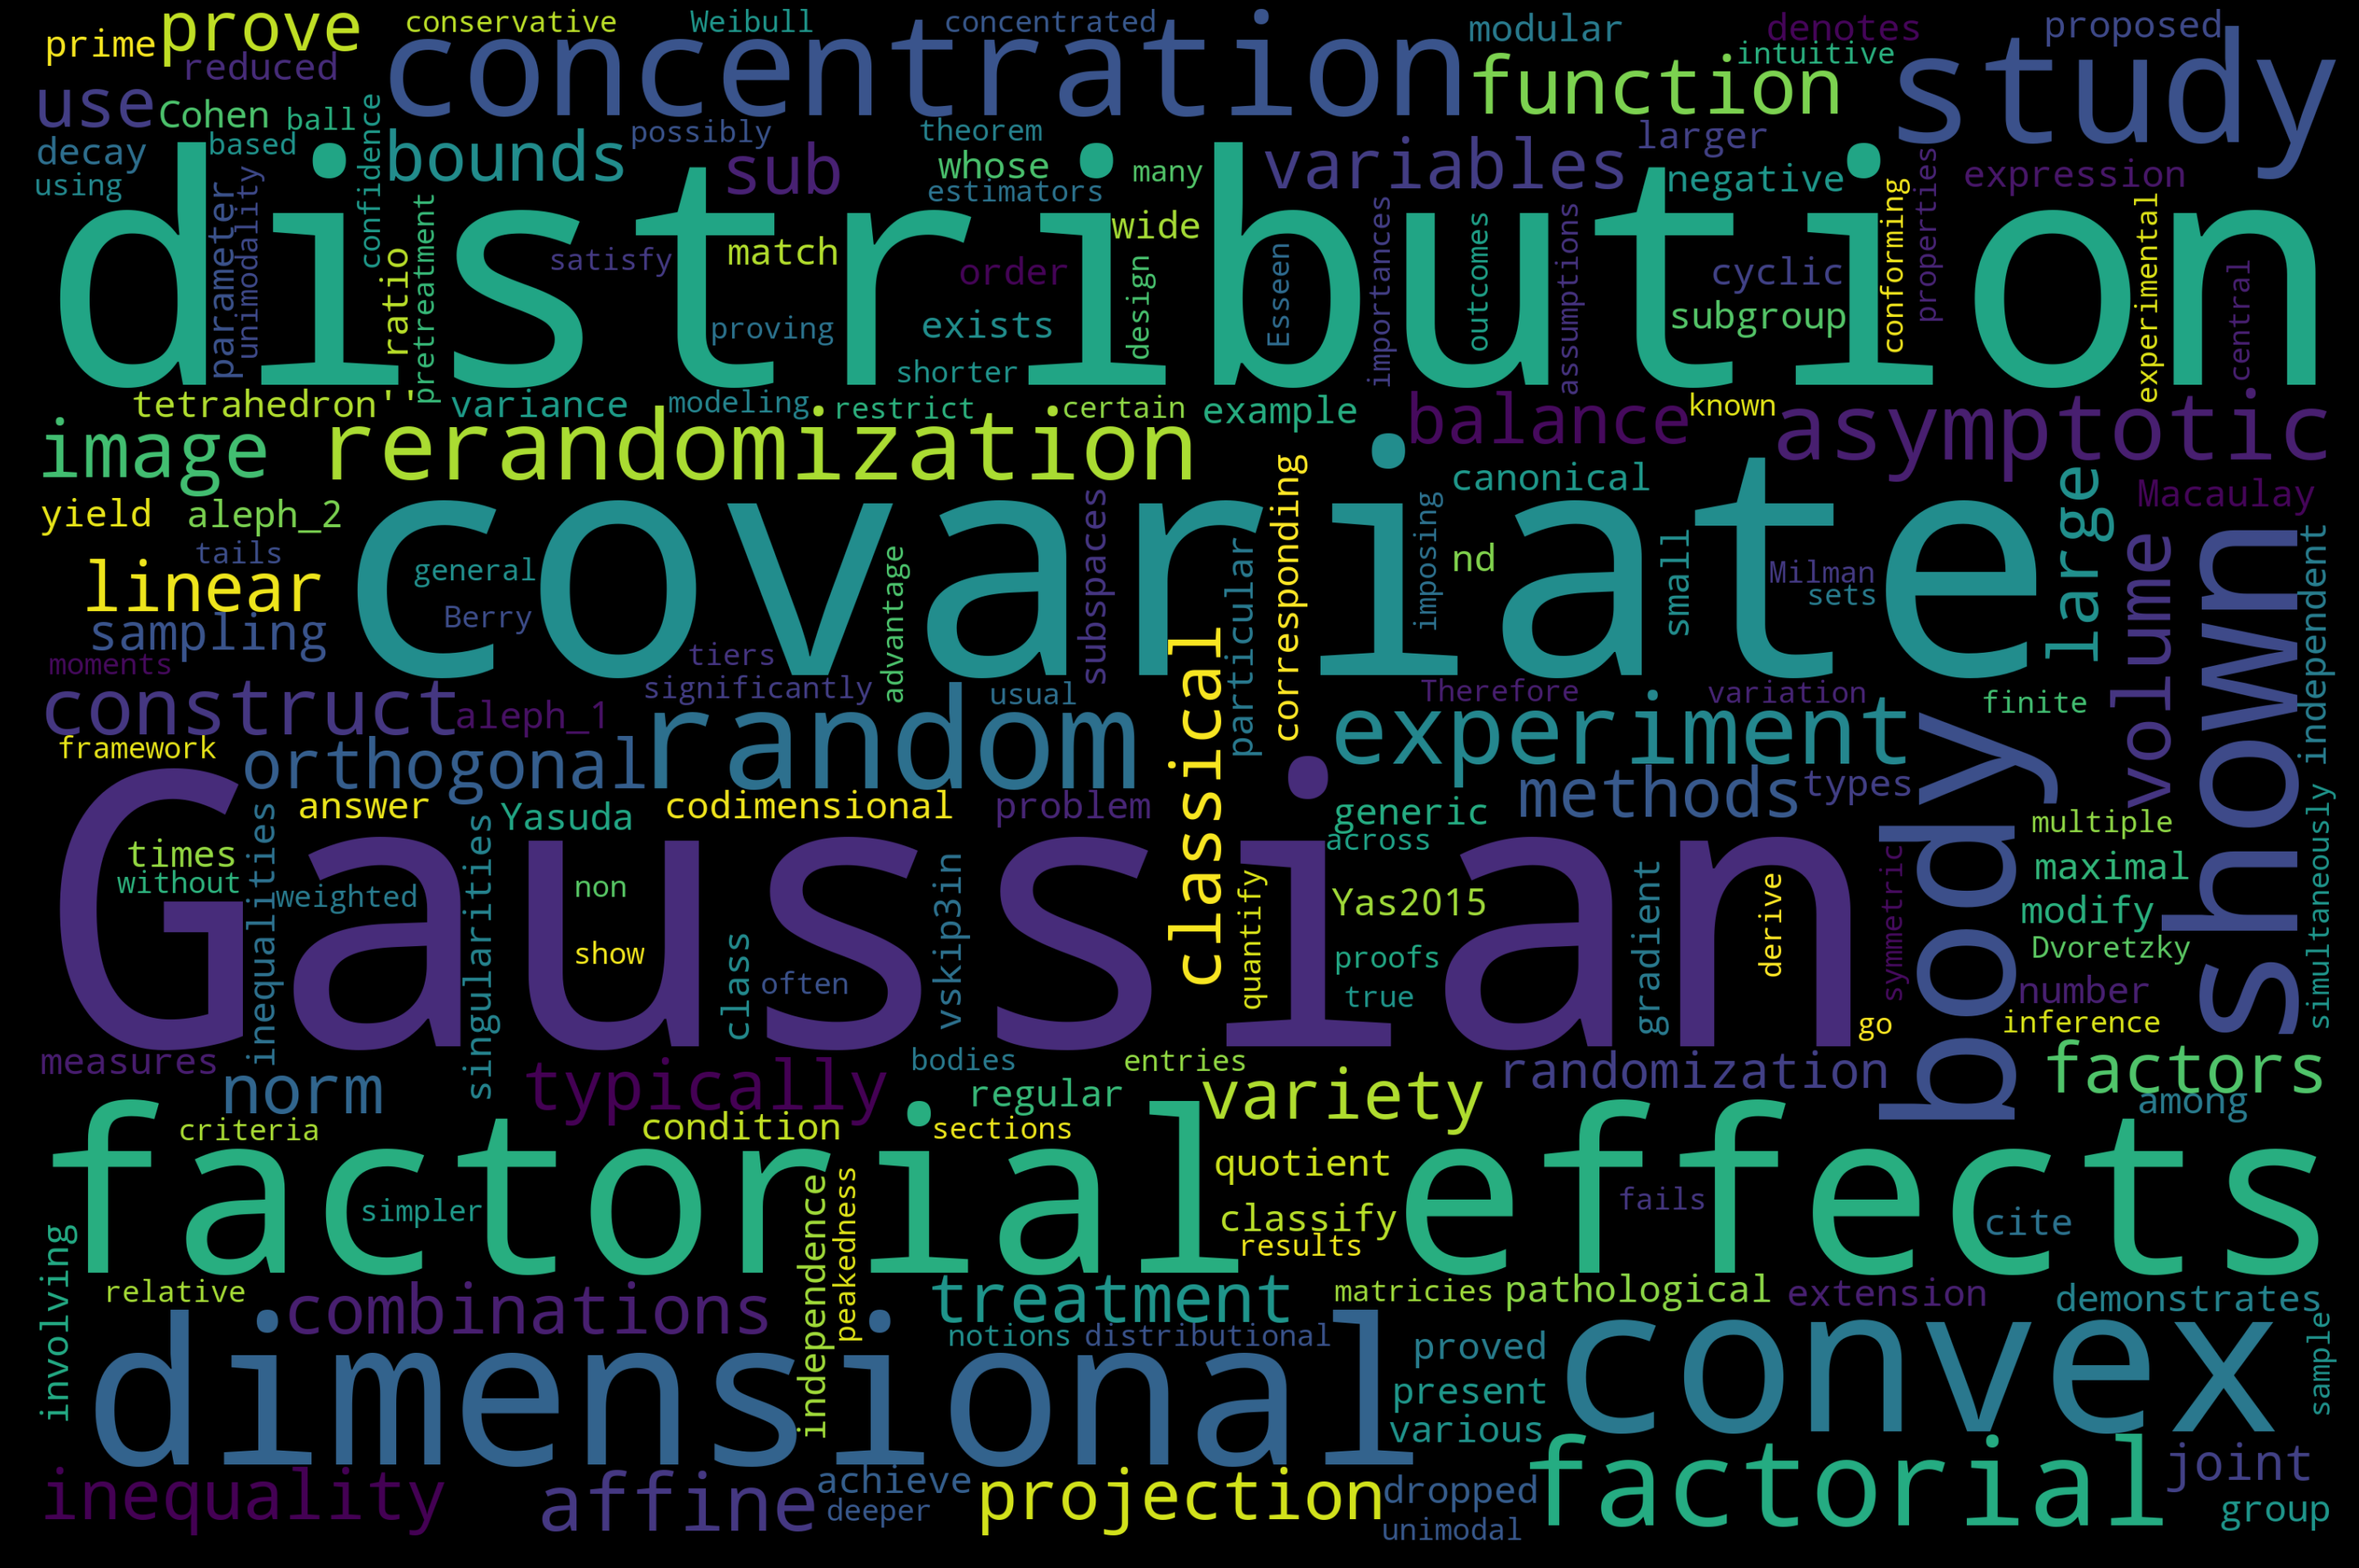

In [14]:
#follow https://mikulskibartosz.name/word-cloud-from-a-pandas-dataframe-f3203cbf757
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
text = df["abstract"].values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### Okay, it seems our plot is a little inclined to probability theory
### Now let's take a closer look of the intersection of algebraic geometry and combinatorics (the fields I am working on)

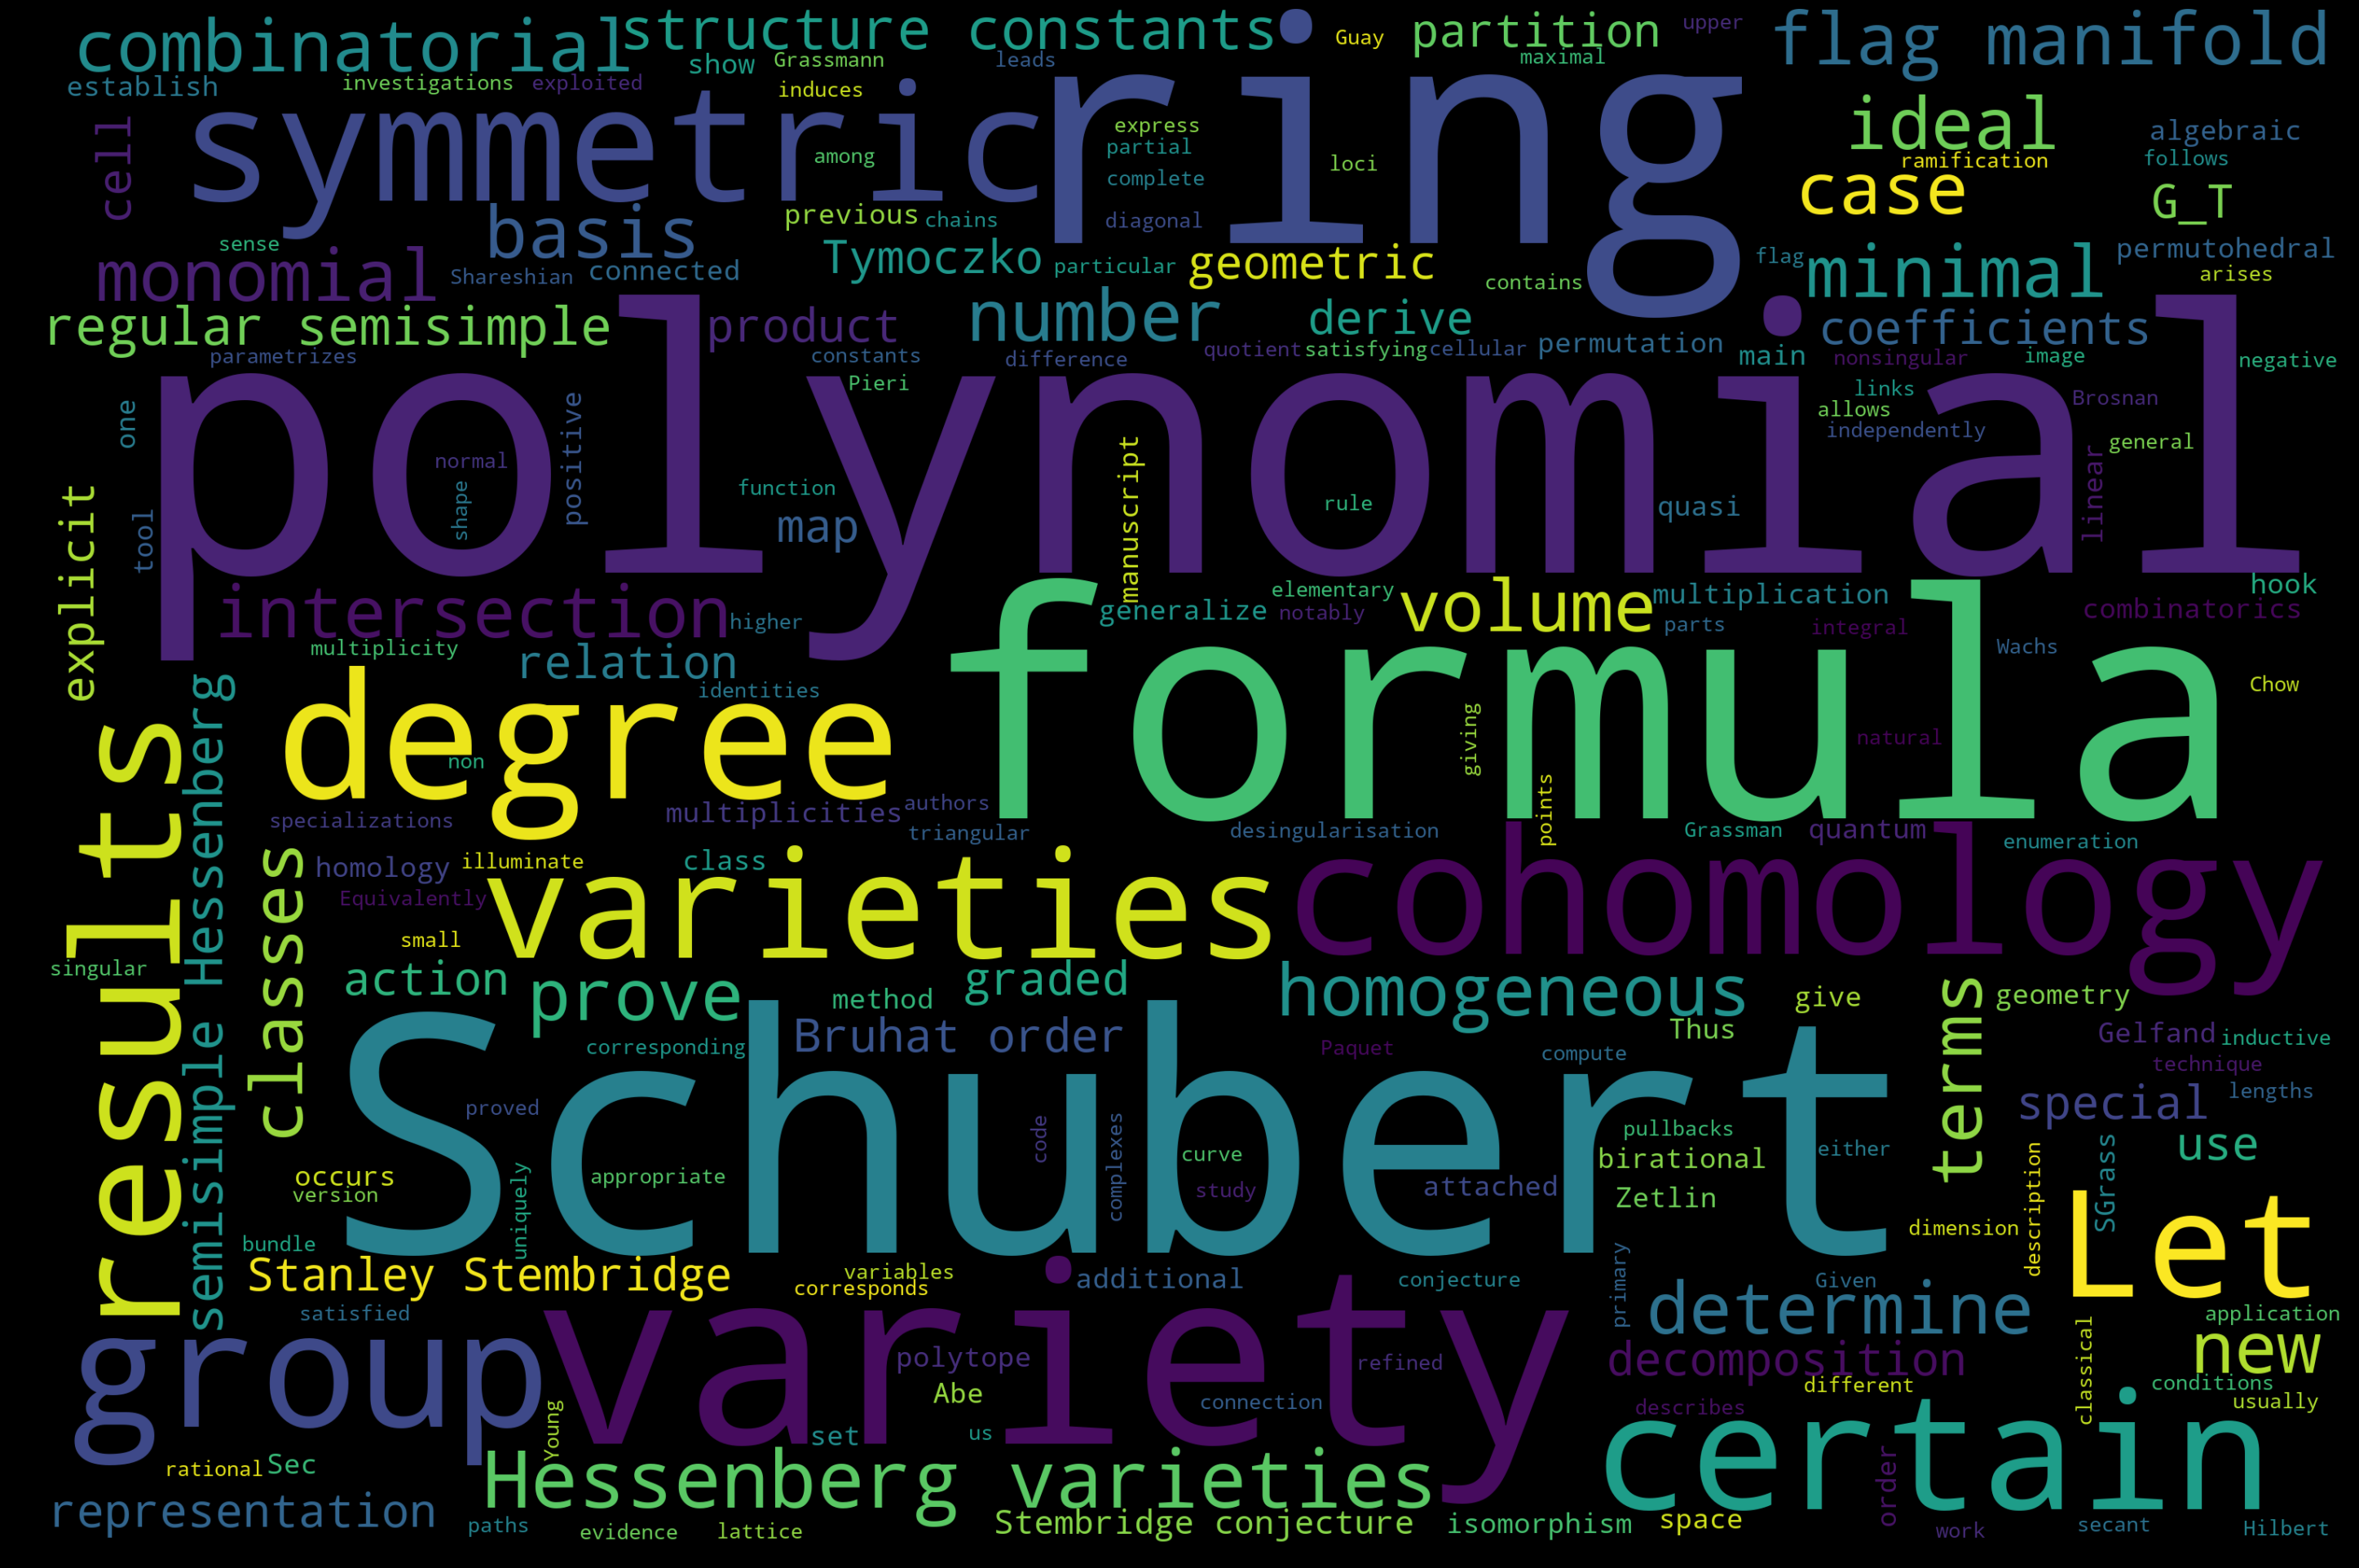

In [15]:
AG_and_CO=df[df["categories"].apply(lambda x: ("math.AG" in x)&("math.CO" in x) )]
text = AG_and_CO["abstract"].values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS,random_state=1).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### flag variety , schubert varieties , polynomials , cohomology etc... Finally I can see some more familiar words!

### what's the trend of arxiv math preprint?
### first we need to sort the data by month

In [16]:
df['created_month']=df['created'].apply(lambda x:datetime.datetime(year=x.year,month=x.month, day=1 ))
number_by_month=df.groupby("created_month").apply(lambda x:len(x))

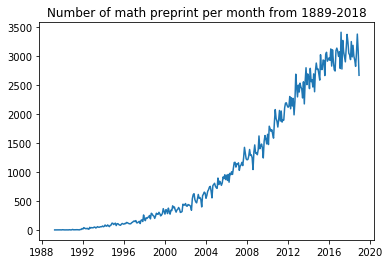

In [17]:
plt.plot(number_by_month)
plt.title("Number of math preprint per month from 1889-2018")
plt.show()


### Apparently, number of preprints submitted to arxiv is increasing and on average around 3000 preprints are submitted to arxiv per month since 2015

### What about the fields I am working on? 

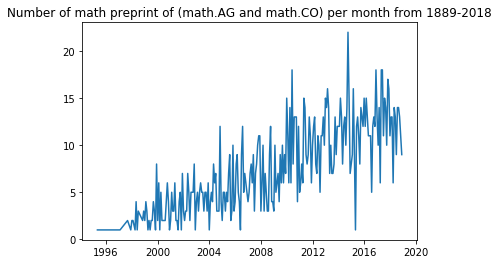

In [18]:
AG_and_CO=df[df["categories"].apply(lambda x: ("math.AG" in x)&("math.CO" in x) )]
number_by_month_AG_and_CO=AG_and_CO.groupby("created_month").apply(lambda x:len(x))
plt.plot(number_by_month_AG_and_CO)
plt.title("Number of math preprint of (math.AG and math.CO) per month from 1889-2018")
plt.show()

### So around 10 to 15 preprints are submitted per month since 2012 (There will be more if you consider algebraic geometry and combinatorics separately)